In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.engine.topology import Layer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib
matplotlib.use("Agg")
from matplotlib import pyplot as plt
import itertools

In [ ]:
def loadall(filename=''):

  '''
  Function to for Loading Data

  '''
  
  tmp = np.load(filename)
  x_tr = tmp['x_tr']
  y_tr = tmp['y_tr']
  x_te = tmp['x_te']
  y_te = tmp['y_te']
  x_cv = tmp['x_cv']
  y_cv = tmp['y_cv']
  return {'x_tr' : x_tr, 'y_tr' : y_tr,
          'x_te' : x_te, 'y_te' : y_te,
          'x_cv' : x_cv, 'y_cv' : y_cv, }

In [ ]:
data = loadall('/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/melspects.npz')
x_tr = data['x_tr']
y_tr = data['y_tr']
x_te = data['x_te']
y_te = data['y_te']
x_cv = data['x_cv']
y_cv = data['y_cv']

print("x_tr:\t", x_tr.shape)
print("y_tr:\t", y_tr.shape)
print("x_te:\t", x_te.shape)
print("y_te:\t", y_te.shape)
print("x_cv:\t", x_cv.shape)
print("y_cv:\t", y_cv.shape)

x_tr:	 (8000, 64, 173)
y_tr:	 (8000,)
x_te:	 (100, 64, 173)
y_te:	 (100,)
x_cv:	 (100, 64, 173)
y_cv:	 (100,)


In [ ]:
x_tr[0].shape

(64, 173)

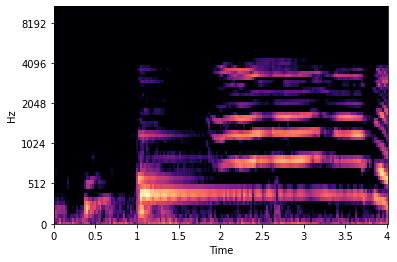

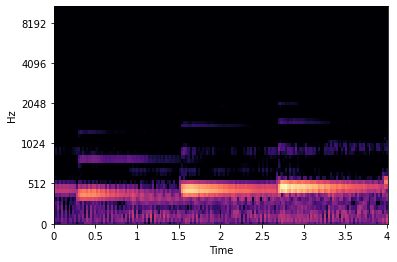

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(x_tr[700], y_axis='mel', x_axis='time', ax=ax)

fig, ax = plt.subplots()
librosa.display.specshow(x_tr[800], y_axis='mel', x_axis='time', ax=ax)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
song_labels = ["Blues","Classical","Country","Disco","Hip hop","Jazz","Metal","Pop","Reggae","Rock"]

In [ ]:
def metric(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

In [ ]:
def cnn(num_genres=10, input_shape=(64,173,1)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(4, 4),
                     activation='relu', #kernel_regularizer=regularizers.l2(0.04),
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 4)))
    model.add(Conv2D(64, (3, 5), activation='relu'
                    , kernel_regularizer=regularizers.l2(0.04)
                    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (2, 2), activation='relu'
       # , kernel_regularizer=regularizers.l2(0.04)
        ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dense(num_genres, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=[metric])
    return(model)

In [ ]:
class model(object):

    def __init__(self, ann_model):
        self.model = ann_model()

    def train_model(self, train_x, train_y,
                val_x=None, val_y=None,
                small_batch_size=200, max_iteration=150, print_interval=1,
                test_x=None, test_y=None):

        m = len(train_x)

        for it in range(max_iteration):

            # split training data into even batches
            batch_idx = np.random.permutation(m)
            train_x = train_x[batch_idx]
            train_y = train_y[batch_idx]

            num_batches = int(m / small_batch_size)
            for batch in range(num_batches):

                x_batch = train_x[ batch*small_batch_size : (batch+1)*small_batch_size]
                y_batch = train_y[ batch*small_batch_size : (batch+1)*small_batch_size]
                print("starting batch\t", batch, "\t Epoch:\t", it)
                self.model.train_on_batch(x_batch, y_batch)

            if it % print_interval == 0:
                validation_accuracy = self.model.evaluate(val_x, val_y)
                training_accuracy = self.model.evaluate(train_x, train_y)
                testing_accuracy = self.model.evaluate(test_x, test_y)
                # print of test error used only after development of the model
                print("\nTraining accuracy: %f\t Validation accuracy: %f\t Testing Accuracy: %f" %
                      (training_accuracy[1], validation_accuracy[1], testing_accuracy[1]))
                print("\nTraining loss: %f    \t Validation loss: %f    \t Testing Loss: %f \n" %
                      (training_accuracy[0], validation_accuracy[0], testing_accuracy[0]))
                print( )

            if (validation_accuracy[1] > .81):
                print("Saving confusion data...")
                model_name = "model" + str(100*validation_accuracy[1]) + str(100*testing_accuracy[1]) + ".h5"
                #self.model.save(model_name) 
                pred = self.model.predict_classes(test_x, verbose=1)
                cnf_matrix = confusion_matrix(np.argmax(test_y, axis=1), pred)
                np.set_printoptions(precision=2)
                plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=song_labels, normalize=True, title='Normalized confusion matrix')
                print(precision_recall_fscore_support(np.argmax(test_y, axis=1),pred, average='macro')) 
                #plt.savefig(str(batch))


In [ ]:
# data = loadall('melspects.npz')

# x_tr = data['x_tr']
# y_tr = data['y_tr']
# x_te = data['x_te']
# y_te = data['y_te']
# x_cv = data['x_cv']
# y_cv = data['y_cv']

tr_idx = np.random.permutation(len(x_tr))
te_idx = np.random.permutation(len(x_te))
cv_idx = np.random.permutation(len(x_cv))

x_tr = x_tr[tr_idx]
y_tr = y_tr[tr_idx]
x_te = x_te[te_idx]
y_te = y_te[te_idx]
x_cv = x_cv[cv_idx]
y_cv = y_cv[cv_idx]

x_tr = x_tr[:,:,:,np.newaxis]
x_te = x_te[:,:,:,np.newaxis]
x_cv = x_cv[:,:,:,np.newaxis]

y_tr = np_utils.to_categorical(y_tr)
y_te = np_utils.to_categorical(y_te)
y_cv = np_utils.to_categorical(y_cv)

In [ ]:
ann = model(cnn)
ann.train_model(x_tr, y_tr, val_x=x_cv, val_y=y_cv, test_x=x_te, test_y=y_te)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


starting batch	 0 	 Epoch:	 0
starting batch	 1 	 Epoch:	 0
starting batch	 2 	 Epoch:	 0
starting batch	 3 	 Epoch:	 0
starting batch	 4 	 Epoch:	 0
starting batch	 5 	 Epoch:	 0
starting batch	 6 	 Epoch:	 0
starting batch	 7 	 Epoch:	 0
starting batch	 8 	 Epoch:	 0
starting batch	 9 	 Epoch:	 0
starting batch	 10 	 Epoch:	 0
starting batch	 11 	 Epoch:	 0
starting batch	 12 	 Epoch:	 0
starting batch	 13 	 Epoch:	 0
starting batch	 14 	 Epoch:	 0
starting batch	 15 	 Epoch:	 0
starting batch	 16 	 Epoch:	 0
starting batch	 17 	 Epoch:	 0
starting batch	 18 	 Epoch:	 0
starting batch	 19 	 Epoch:	 0
starting batch	 20 	 Epoch:	 0
starting batch	 21 	 Epoch:	 0
starting batch	 22 	 Epoch:	 0
starting batch	 23 	 Epoch:	 0
starting batch	 24 	 Epoch:	 0
starting batch	 25 	 Epoch:	 0
starting batch	 26 	 Epoch:	 0
starting batch	 27 	 Epoch:	 0
starting batch	 28 	 Epoch:	 0
starting batch	 29 	 Epoch:	 0
starting batch	 30 	 Epoch:	 0
starting batch	 31 	 Epoch:	 0
starting batch	 32

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


4/4 [==============================] - 1s 6ms/step
Confusion matrix
[[0.3 0.  0.2 0.1 0.  0.  0.  0.  0.2 0.2]
 [0.  0.9 0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.2 0.4 0.  0.  0.  0.1 0.  0.  0.3]
 [0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.  0.  0.  0.9 0.  0.  0.1 0.  0. ]
 [0.  0.3 0.2 0.  0.  0.3 0.  0.  0.  0.2]
 [0.  0.  0.  0.  0.  0.  0.8 0.  0.1 0.1]
 [0.  0.  0.  0.  0.1 0.  0.  0.9 0.  0. ]
 [0.  0.  0.2 0.1 0.  0.  0.  0.1 0.4 0.2]
 [0.  0.  0.2 0.1 0.  0.  0.1 0.  0.  0.6]]
(0.6876406926406926, 0.6300000000000001, 0.6221953536659419, None)
starting batch	 0 	 Epoch:	 15
starting batch	 1 	 Epoch:	 15
starting batch	 2 	 Epoch:	 15
starting batch	 3 	 Epoch:	 15
starting batch	 4 	 Epoch:	 15
starting batch	 5 	 Epoch:	 15
starting batch	 6 	 Epoch:	 15
starting batch	 7 	 Epoch:	 15
starting batch	 8 	 Epoch:	 15
starting batch	 9 	 Epoch:	 15
starting batch	 10 	 Epoch:	 15
starting batch	 11 	 Epoch:	 15
starting batch	 12 	 Epoch:	 15
starting batch	 13 	 Epoch:	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


starting batch	 0 	 Epoch:	 85
starting batch	 1 	 Epoch:	 85
starting batch	 2 	 Epoch:	 85
starting batch	 3 	 Epoch:	 85
starting batch	 4 	 Epoch:	 85
starting batch	 5 	 Epoch:	 85
starting batch	 6 	 Epoch:	 85
starting batch	 7 	 Epoch:	 85
starting batch	 8 	 Epoch:	 85
starting batch	 9 	 Epoch:	 85
starting batch	 10 	 Epoch:	 85
starting batch	 11 	 Epoch:	 85
starting batch	 12 	 Epoch:	 85
starting batch	 13 	 Epoch:	 85
starting batch	 14 	 Epoch:	 85
starting batch	 15 	 Epoch:	 85
starting batch	 16 	 Epoch:	 85
starting batch	 17 	 Epoch:	 85
starting batch	 18 	 Epoch:	 85
starting batch	 19 	 Epoch:	 85
starting batch	 20 	 Epoch:	 85
starting batch	 21 	 Epoch:	 85
starting batch	 22 	 Epoch:	 85
starting batch	 23 	 Epoch:	 85
starting batch	 24 	 Epoch:	 85
starting batch	 25 	 Epoch:	 85
starting batch	 26 	 Epoch:	 85
starting batch	 27 	 Epoch:	 85
starting batch	 28 	 Epoch:	 85
starting batch	 29 	 Epoch:	 85
starting batch	 30 	 Epoch:	 85
starting batch	 31